In [1]:
target_size = (224,224)
batch_size = 32
train_val_split = 0.2
num_classes = 5
nb_epochs =100
#init_epoch = 29
wandb_resume_state = True
exp_name = 'test7'
IMG_SHAPE = (224, 224)
classes = 5

In [2]:
import shutil
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from keras.models import save_model
import cv2
from tensorflow.keras.metrics import AUC, Precision, Recall
import wandb
from wandb.keras import WandbCallback

In [3]:
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
train_val_split = 0.2

In [5]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (224,224), batch_size = 20, class_mode = 'categorical', subset='training') 
validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/customdataset/Feature_Extraction', target_size = (224,224), batch_size = 20,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [6]:
labels = list(train_generator.class_indices.keys())

In [7]:
from tensorflow.keras.applications import VGG19
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

In [8]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the VGG19 model
for layer in base_model.layers:
    layer.trainable = False

    # Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)

    # Add dropout with a rate of 0.5
x = Dropout(0.5)(x)

    # Add the output layer with 5 units and softmax activation
predictions = Dense(5, activation='softmax')(x)

    # Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(),  Recall(), AUC()])


80150528/80134624 [==============================] - 0s 0us/step


In [9]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping( patience=3, verbose=1)

In [10]:
history = model.fit(train_generator,steps_per_epoch = len(train_generator),
                          validation_data = validation_generator,
                          validation_steps =len( validation_generator),epochs = nb_epochs ,callbacks=[early_stopping])

Epoch 1/100
147/147 [==============================] - 44s 210ms/step - loss: 1.0875 - accuracy: 0.6199 - precision: 0.7718 - recall: 0.4534 - auc: 0.8456 - val_loss: 0.8830 - val_accuracy: 0.6813 - val_precision: 0.9070 - val_recall: 0.4405 - val_auc: 0.9009
Epoch 2/100
147/147 [==============================] - 21s 145ms/step - loss: 0.8966 - accuracy: 0.6892 - precision: 0.8180 - recall: 0.5336 - auc: 0.8961 - val_loss: 0.8239 - val_accuracy: 0.6895 - val_precision: 0.8273 - val_recall: 0.5636 - val_auc: 0.9164
Epoch 3/100
147/147 [==============================] - 22s 151ms/step - loss: 0.8452 - accuracy: 0.6974 - precision: 0.8191 - recall: 0.5701 - auc: 0.9091 - val_loss: 0.8062 - val_accuracy: 0.6977 - val_precision: 0.8107 - val_recall: 0.6033 - val_auc: 0.9165
Epoch 4/100
147/147 [==============================] - 23s 153ms/step - loss: 0.8159 - accuracy: 0.7093 - precision: 0.8130 - recall: 0.5889 - auc: 0.9149 - val_loss: 0.8162 - val_accuracy: 0.6963 - val_precision: 0.8731

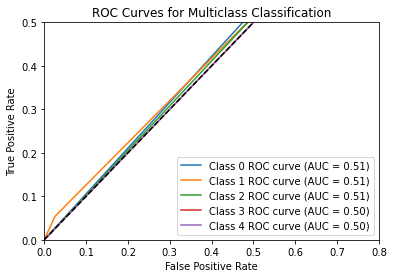

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error,mean_absolute_error
import numpy as np
# Make predictions for the test set
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)
y_true = validation_generator.classes

# Binarize the true labels and predictions
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

# Compute the AUC for each class
aucs = []
for i in range(y_true_bin.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
    aucs.append(auc)
    plt.plot(fpr, tpr, label='Class {} ROC curve (AUC = {:.2f})'.format(i, auc))

plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 0.8])
plt.ylim([0.0, 0.5])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()
y_true = np.argmax(y_true_bin, axis=1)
y_pred = np.argmax(y_pred_bin, axis=1)


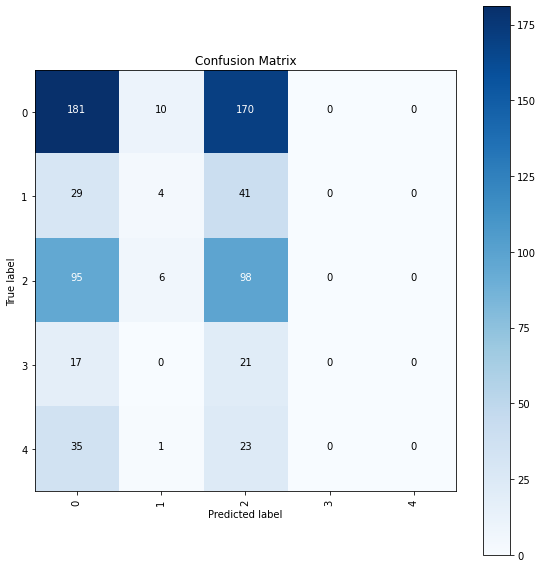

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

# Generate predictions for the test set
#y_pred = model.predict(validation_generator)
#y_pred = np.argmax(y_pred,axis=1)
#y_true = validation_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = validation_generator.class_indices.keys()

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


In [13]:
#save model
model_json = model.to_json()
with open('model_vgg19.json', 'w') as json_file:
    json_file.write(model_json)

model_saved = save_model(model, './weights.hdf5')
#load model
with open('model_vgg19.json', 'r') as json_file:
    json_saved_model = json_file.read()

model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('weights.hdf5')
model_loaded.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#test single image
path = '/kaggle/input/traindata/train/3/0104b032c141.png'
image = cv2.imread(path)
image = cv2.resize(image, (224,224))
image = image/ 255    #normalise
#print(image.shape)
image = image.reshape(-1, 224,224,3)      #reshape in format to send more than one image to predict
#print(image.shape)

result = model_loaded(image)
#print(result)  #probabilities that the image belong to each class
result = np.argmax(result, axis=1)

if(result==0):
    print('Grade 0')
elif(result == 1):
    print('Grade 1')
elif(result == 2):
    print('Grade 2')
elif(result == 3):
    print('Grade 3')
else:
    print('Grade 4')

Grade 2


In [14]:
#train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=train_val_split)
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    validation_split=train_val_split)
r_train_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (224,224), batch_size = 32, class_mode = 'categorical', subset='training') 
r_validation_generator = train_data_gen.flow_from_directory( directory='/kaggle/input/redlesion-customdataset/RedLesion_CustomDataset', target_size = (224,224), batch_size = 32,  class_mode = 'categorical', subset='validation')

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [ ]:
history = model.fit(r_train_generator,steps_per_epoch = len(r_train_generator),
                          validation_data = r_validation_generator,
                          validation_steps =len(r_validation_generator),epochs = nb_epochs,callbacks=[early_stopping])

Epoch 1/100
92/92 [==============================] - 403s 4s/step - loss: 1.0972 - accuracy: 0.6049 - precision: 0.7043 - recall: 0.4452 - auc: 0.8454 - val_loss: 0.9297 - val_accuracy: 0.6389 - val_precision: 0.7605 - val_recall: 0.4952 - val_auc: 0.8907
Epoch 2/100
92/92 [==============================] - 375s 4s/step - loss: 0.9279 - accuracy: 0.6551 - precision: 0.7809 - recall: 0.4814 - auc: 0.8901 - val_loss: 0.8737 - val_accuracy: 0.6607 - val_precision: 0.8411 - val_recall: 0.4706 - val_auc: 0.9059
Epoch 3/100
92/92 [==============================] - 335s 4s/step - loss: 0.8942 - accuracy: 0.6663 - precision: 0.7865 - recall: 0.5015 - auc: 0.8982 - val_loss: 0.8488 - val_accuracy: 0.6607 - val_precision: 0.8447 - val_recall: 0.4761 - val_auc: 0.9109
Epoch 4/100
92/92 [==============================] - 387s 4s/step - loss: 0.8654 - accuracy: 0.6694 - precision: 0.8050 - recall: 0.5128 - auc: 0.9052 - val_loss: 0.8322 - val_accuracy: 0.6799 - val_precision: 0.8877 - val_recall: 0